NOTEBOOK JUPYTER 

In [1]:
import torch
import numpy as np
from  torch import nn

In [2]:
class LineNetwork(nn.Module):
  # Inicialização
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 1)
    )

  # Como a rede computa
  def forward(self, x):
    return self.layers(x)

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [4]:
class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [5]:
line = lambda x: 2*x + 3
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [6]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [8]:
model = LineNetwork().to(device)

In [10]:
# Função de perda (loss function)
# Erro quadrático médio (Mean Squared Error)
lossfunc = nn.MSELoss()
# Gradiente Descendente Estocástico
# SGD = Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# taxa de aprendizado lr = learning rate

In [11]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    # zera os gradientes acumulados
    optimizer.zero_grad()
    # computa os gradientes
    loss.backward()
    # anda, de fato, na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor; item pra obter o float
    cumloss += loss.item() 
  
  return cumloss / len(dataloader)


def test(model, dataloader, lossfunc):
  model.eval()
  
  cumloss = 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(X)
      loss = lossfunc(pred, y)
      cumloss += loss.item() 
  
  return cumloss / len(dataloader)
     

In [12]:
import matplotlib.pyplot as plt

In [13]:
# Pra visualizar
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()
     


Epoch: 0; Train Loss: 215.045654296875


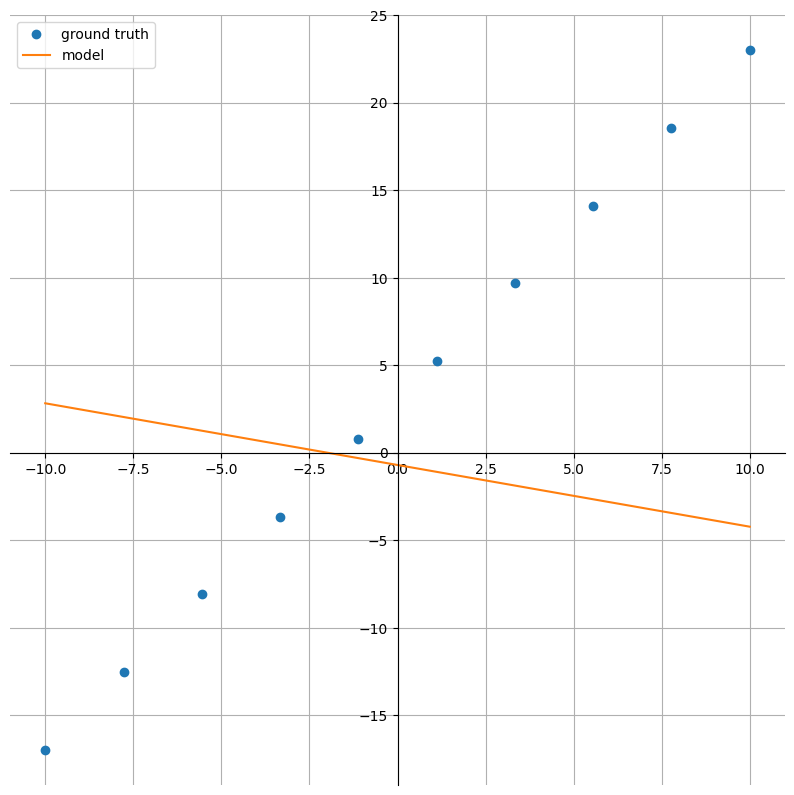

Epoch: 10; Train Loss: 66.21730041503906


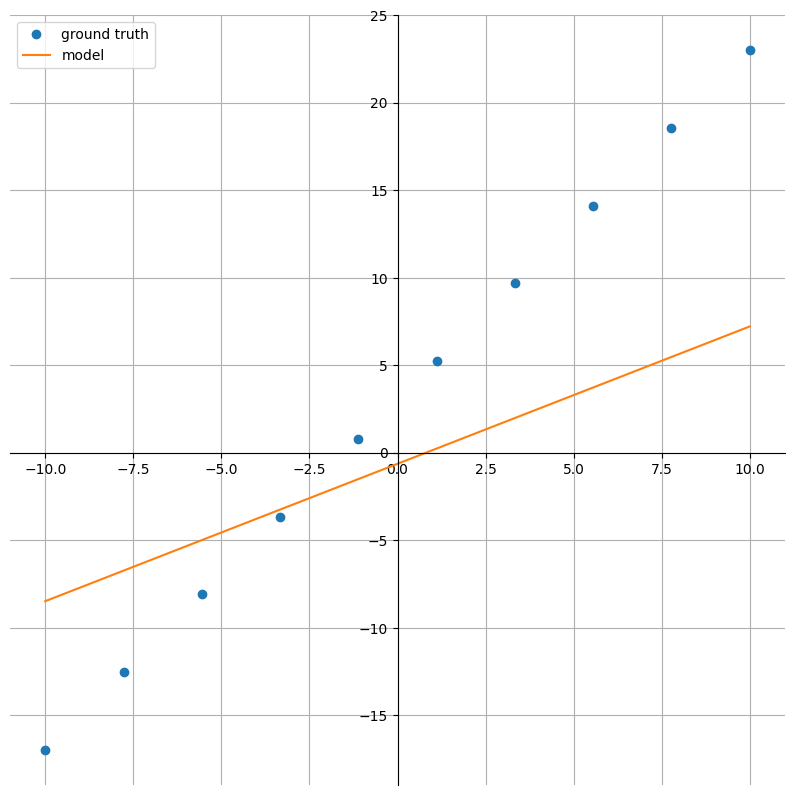

Epoch: 20; Train Loss: 26.736522674560547


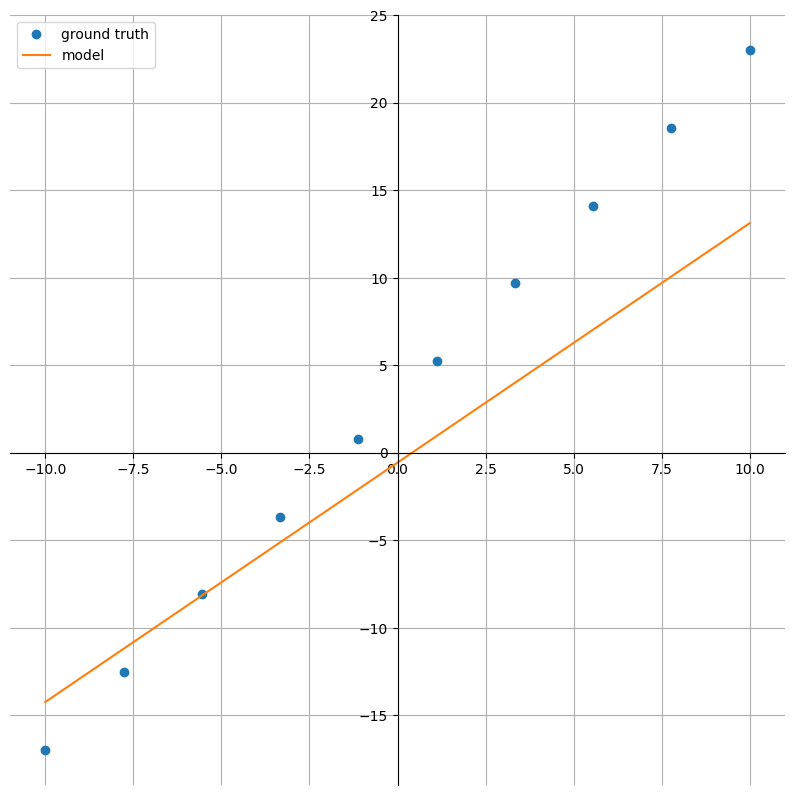

Epoch: 30; Train Loss: 15.998014450073242


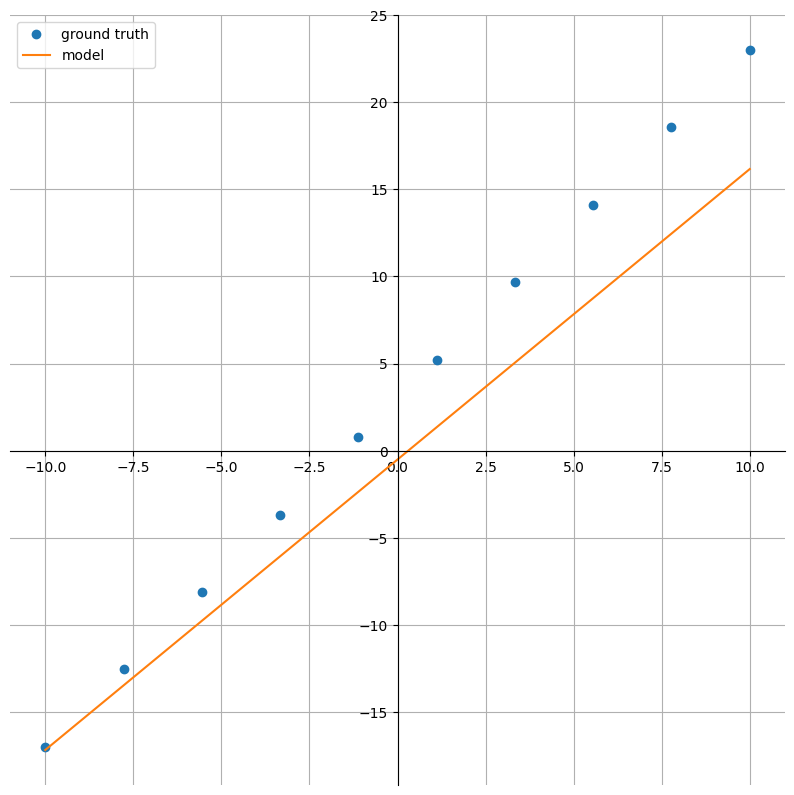

Epoch: 40; Train Loss: 12.824918746948242


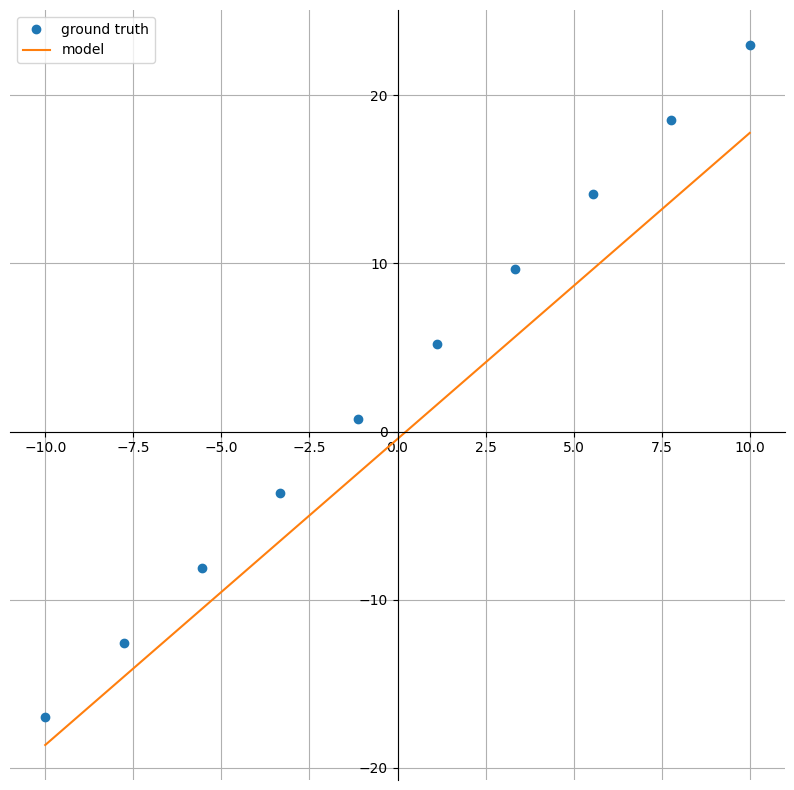

Epoch: 50; Train Loss: 11.653180122375488


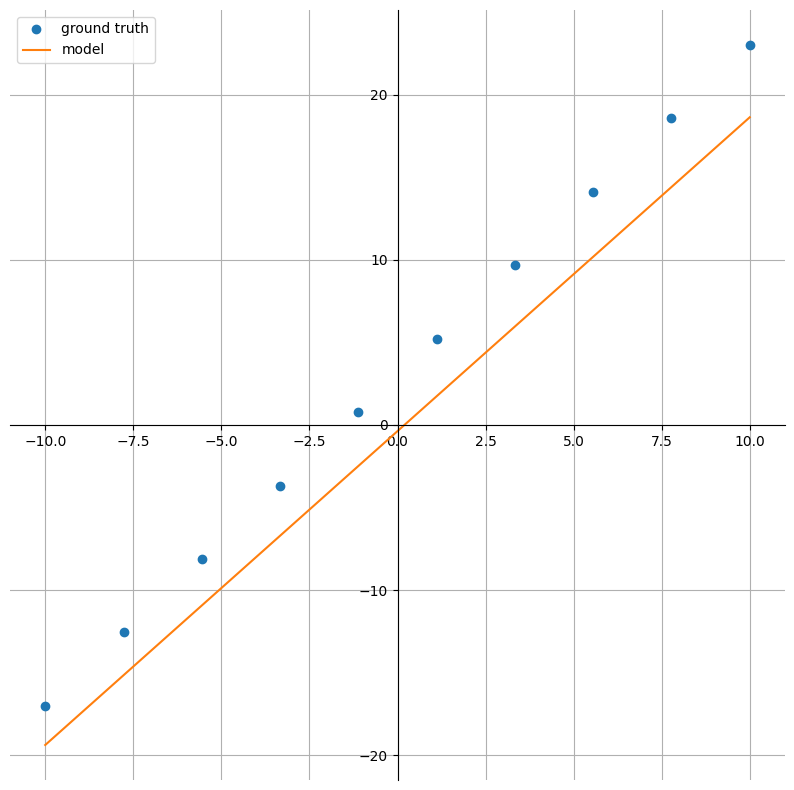

Epoch: 60; Train Loss: 11.020485877990723


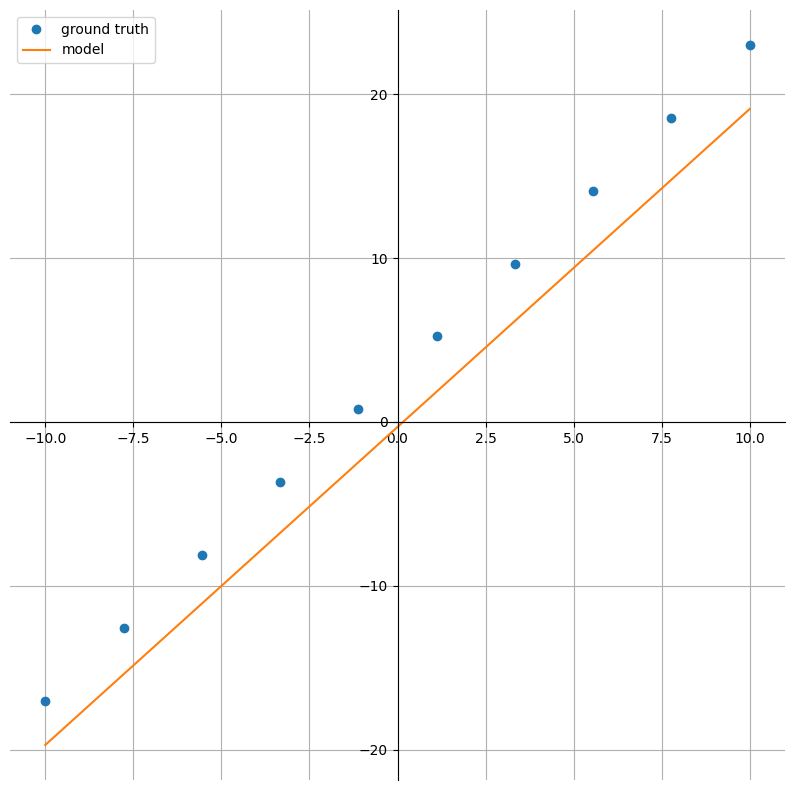

Epoch: 70; Train Loss: 10.542149543762207


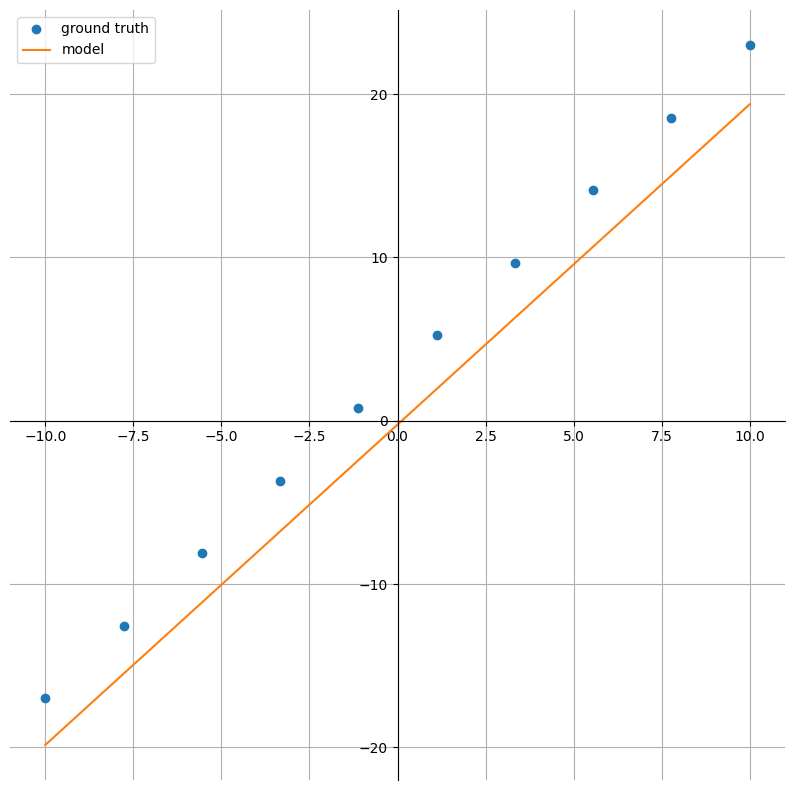

Epoch: 80; Train Loss: 10.11660385131836


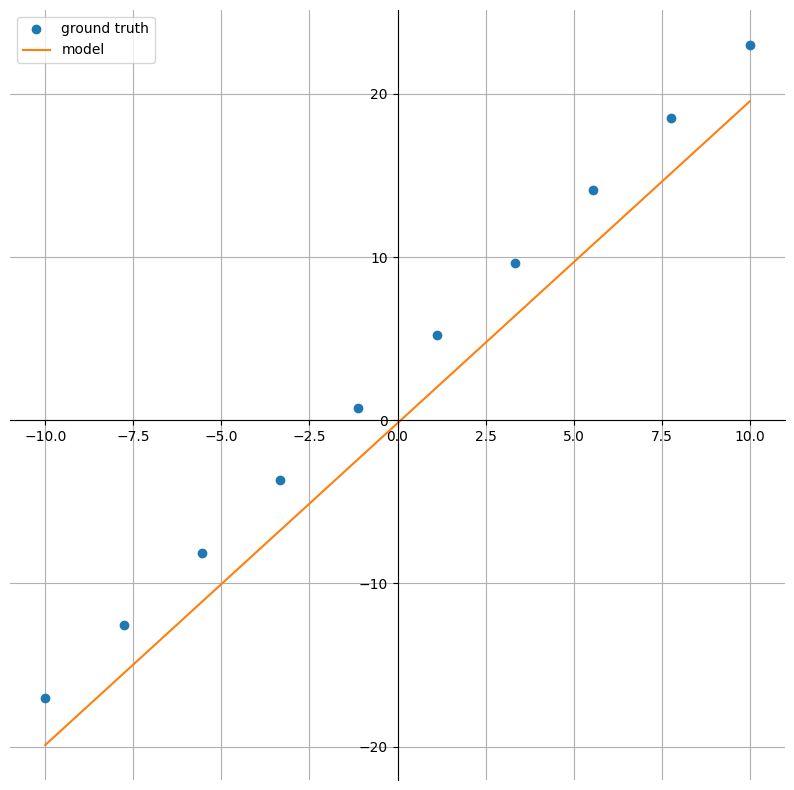

Epoch: 90; Train Loss: 9.71668529510498


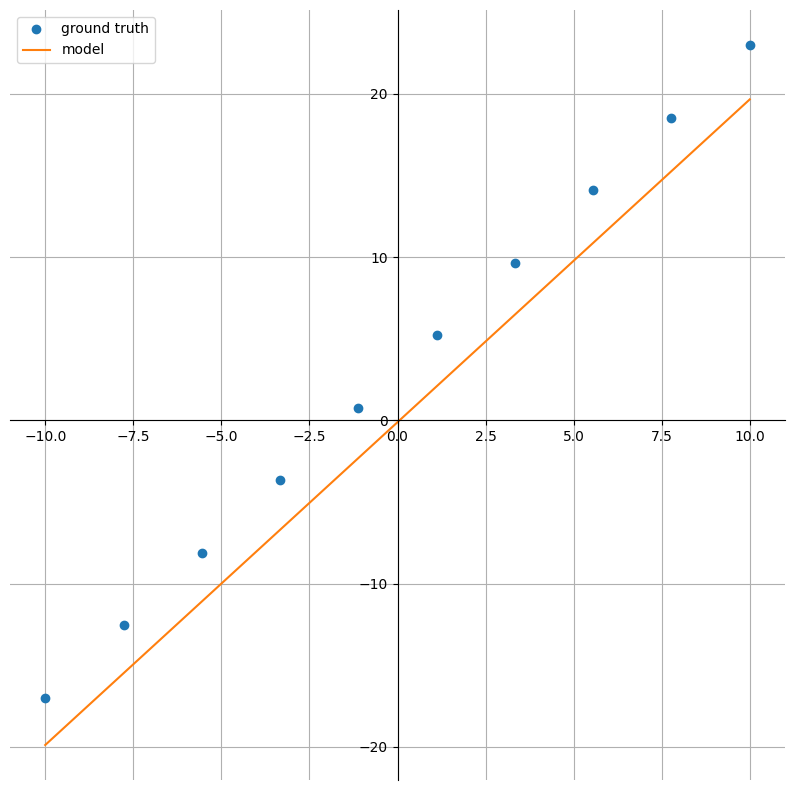

Epoch: 100; Train Loss: 9.334799766540527


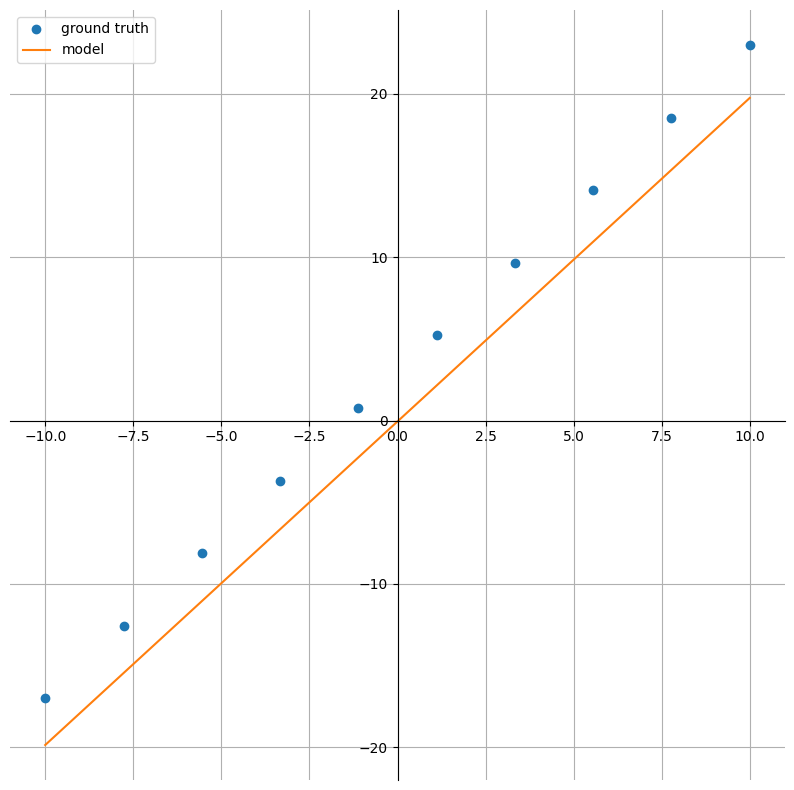

Epoch: 110; Train Loss: 8.968509674072266


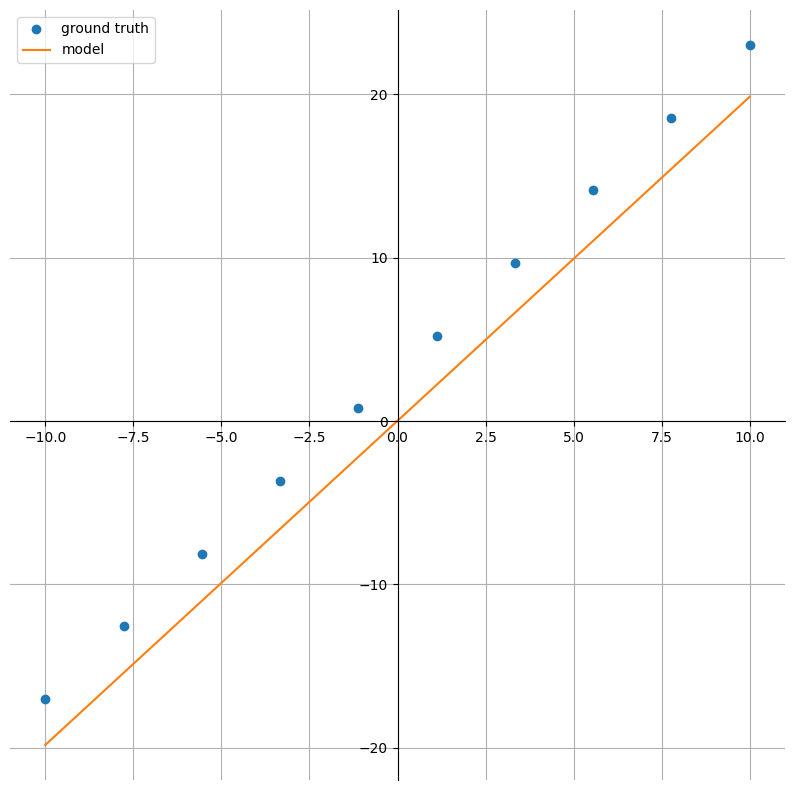

Epoch: 120; Train Loss: 8.616743087768555


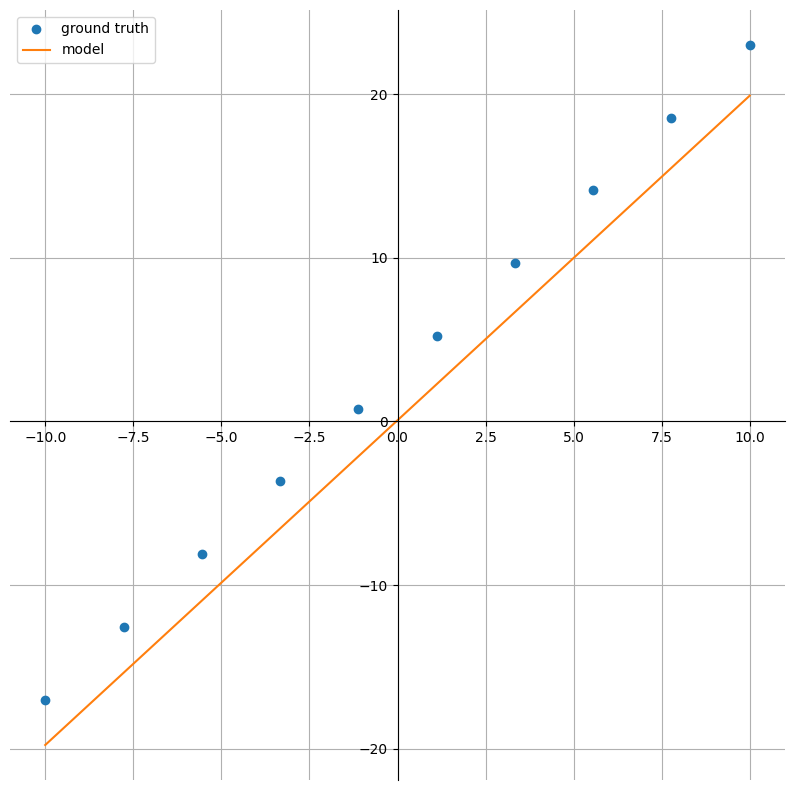

Epoch: 130; Train Loss: 8.278817176818848


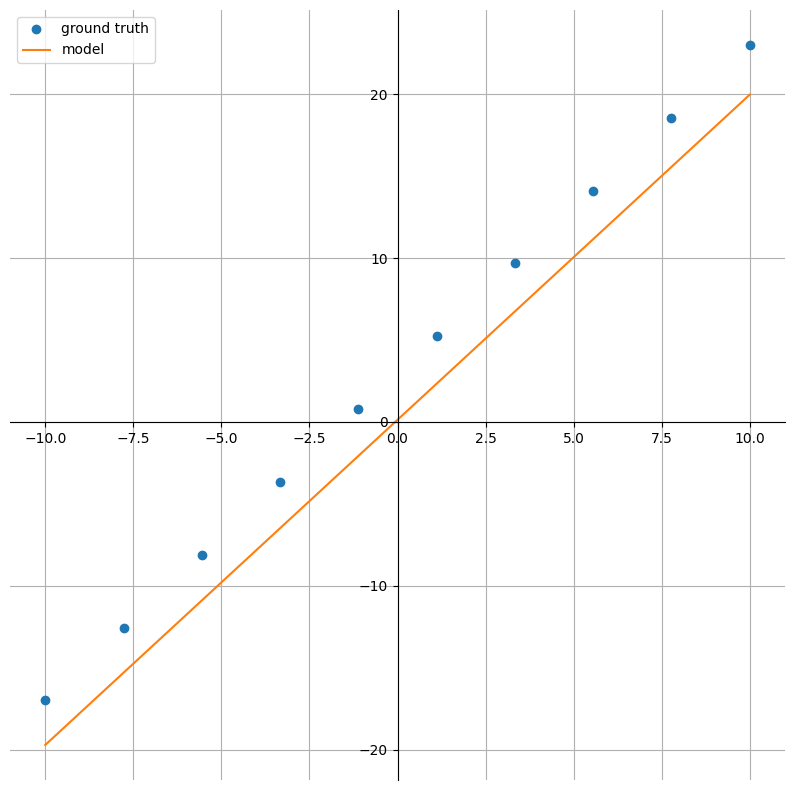

Epoch: 140; Train Loss: 7.954151630401611


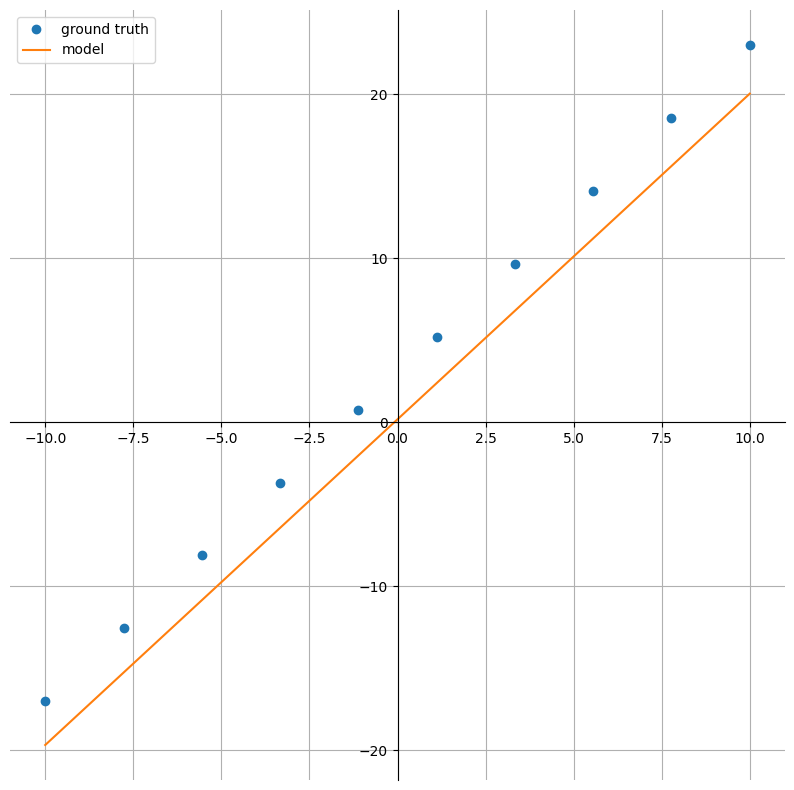

Epoch: 150; Train Loss: 7.642221450805664


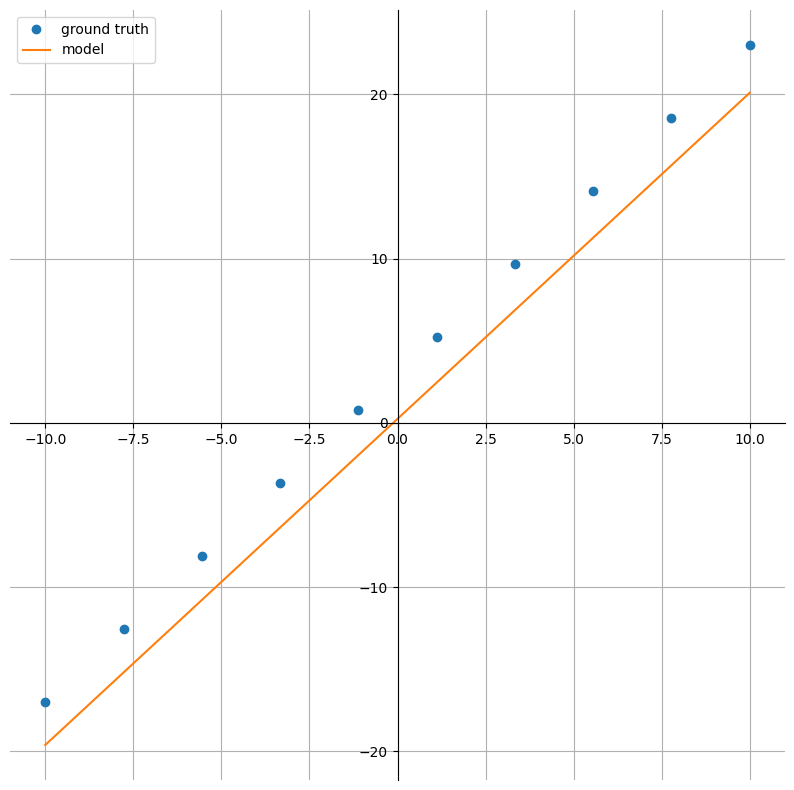

Epoch: 160; Train Loss: 7.342526912689209


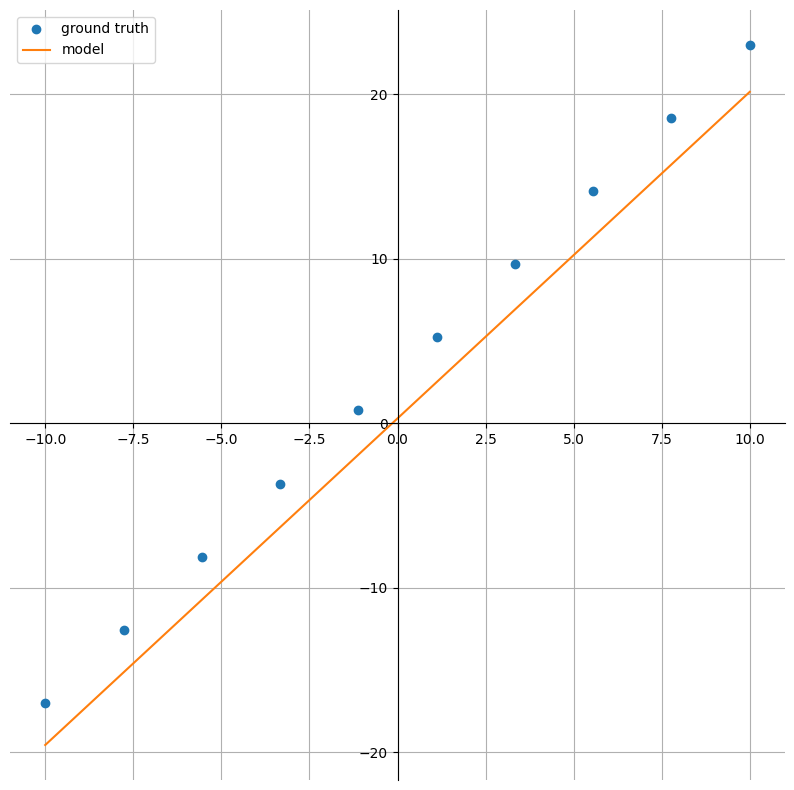

Epoch: 170; Train Loss: 7.054583549499512


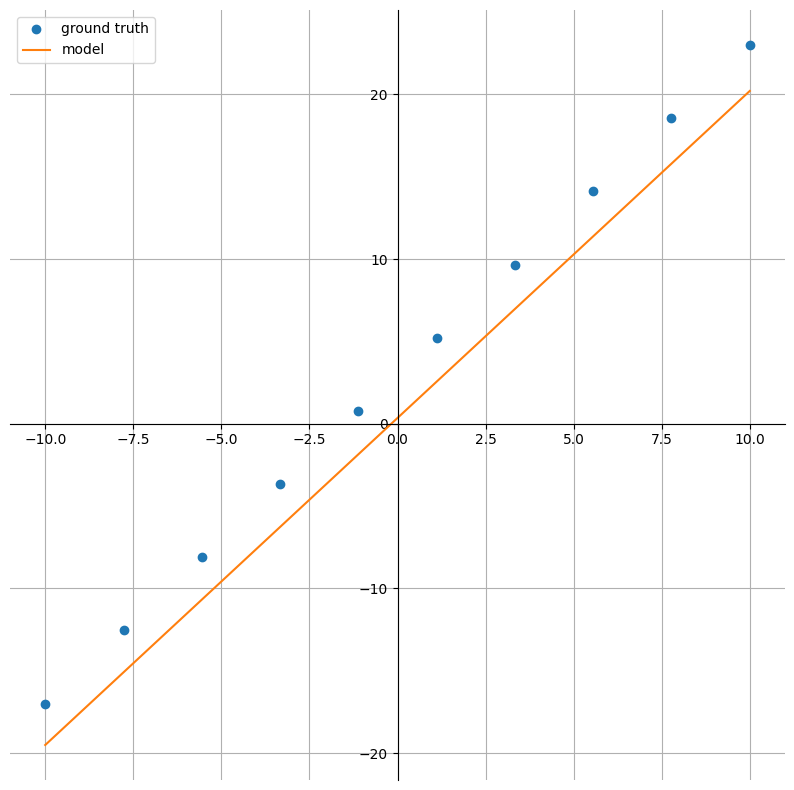

Epoch: 180; Train Loss: 6.777930736541748


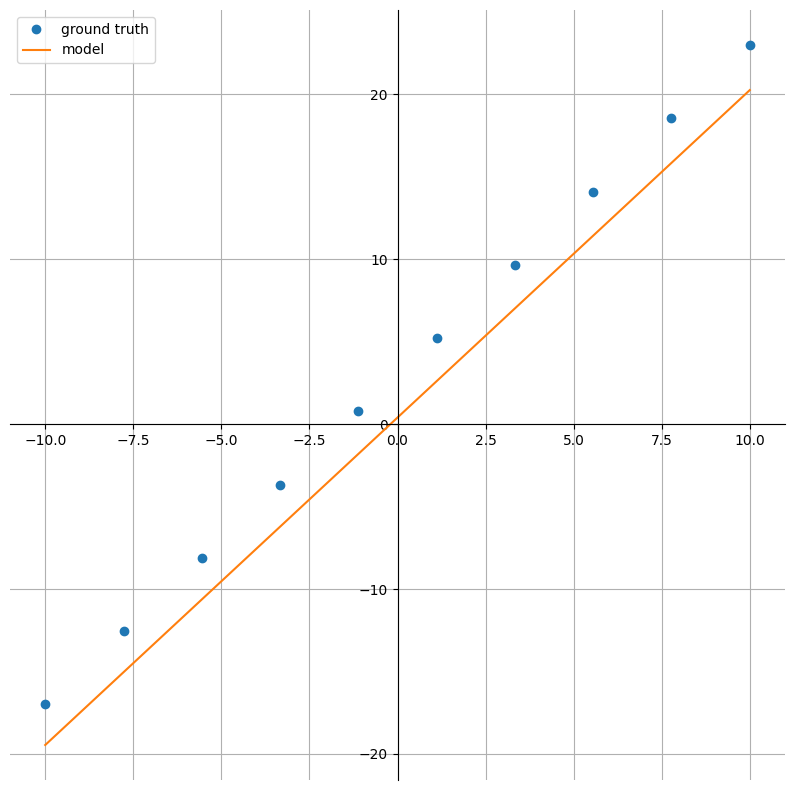

Epoch: 190; Train Loss: 6.512127876281738


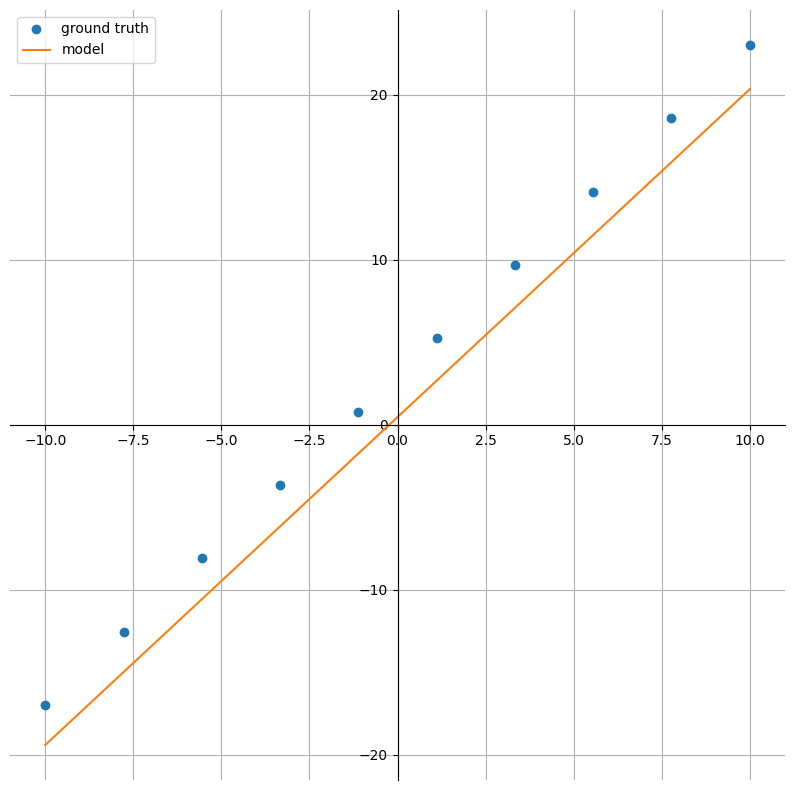

Epoch: 200; Train Loss: 6.256752014160156


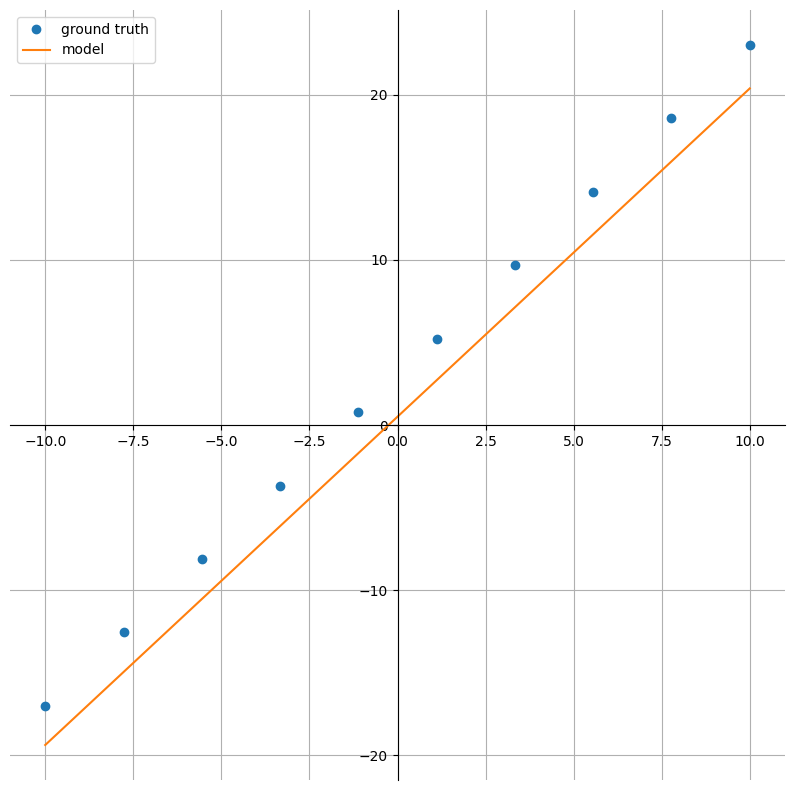

Test Loss: 6.217729091644287


In [14]:
epochs = 201
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(line, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")